# Deep Learning for timeseries

chapter covers:

*   Examples of machine learning tasks that involve timeseries data
*   temperature forecasting example
*   advanced rnn usage patterns



other things you can do with timeseries:
- Classification—Assign one or more categorical labels to a timeseries. For instance, given the timeseries of the activity of a visitor on a website, classify whether the visitor is a bot or a human.
- Event detection—Identify the occurrence of a specific expected event within a continuous data stream. A particularly useful application is “hotword detection,” where a model monitors an audio stream and detects utterances like “Ok Google” or “Hey Alexa.”
- Anomaly detection—Detect anything unusual happening within a continuous datastream. Unusual activity on your corporate network? Might be an attacker. Unusual readings on a manufacturing line? Time for a human to go take a look. Anomaly detection is typically done via unsupervised learning, because you often don’t know what kind of anomaly you’re looking for, so you can’t train on specific anomaly examples.

## 10.2 A temperature-forecasting example

We’ll work with a weather timeseries dataset recorded at the weather station at the Max Planck Institute for Biogeochemistry in Jena, Germany.1 In this dataset, 14 different quantities (such as temperature, pressure, humidity, wind direction, and so on) were recorded every 10 minutes over several years.

In [1]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2026-01-07 15:59:23--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.130.224, 16.15.207.101, 16.182.96.64, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.130.224|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  19.2MB/s    in 0.7s    

2026-01-07 15:59:24 (19.2 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


### looking at the data

In [2]:
import os

fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
  data = f.read()
lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


Now, convert all 420,551 lines of data into NumPy arrays: one array for the temperature (in degrees Celsius), and another one for the rest of the data—the features we will use to predict future temperatures. Note that we discard the “Date Time” column.

In [3]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
  values = [float (x) for x in line.split(",") [1:]]
  temperature[i] = values[1]
  raw_data[i, :] = values[:]

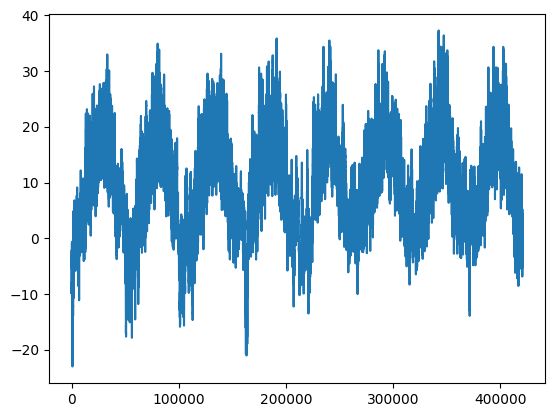

In [4]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

plotting the first 10 days of the temperature timeseries.

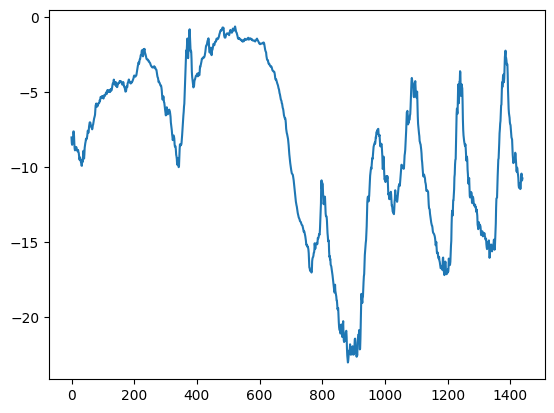

In [5]:
plt.plot(range(1440), temperature[:1440])

In all our experiments, we’ll use the first 50% of the data for training, the following 25% for validation, and the last 25% for testing. When working with timeseries data, it’s important to use validation and test data that is more recent than the training data, because you’re trying to predict the future given the past, not the reverse

In [6]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


### preparing the data

given that all columns are in different scales, we'll normalize them

In [7]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

Next, let’s create a Dataset object that yields batches of data from the past five days along with a target temperature 24 hours in the future. Because the samples in the dataset are highly redundant (sample N and sample N + 1 will have most of their timesteps in common), it would be wasteful to explicitly allocate memory for every sample. Instead, we’ll generate the samples on the fly while only keeping in memory the original raw_data and temperature arrays, and nothing more.

there’s a built-in dataset utility in Keras (timeseries_dataset_from_array())

The general idea is that you provide an array of timeseries data (the data argument), and timeseries_dataset_from_array() gives you windows extracted from the original timeseries (we’ll call them “sequences”).

For example, if you use data = [0 1 2 3 4 5 6] and sequence_length=3, then timeseries_dataset_from_array() will generate the following samples: [0 1 2], [1 2 3], [2 3 4], [3 4 5], [4 5 6].

We’ll use timeseries_dataset_from_array() to instantiate three datasets: one for training, one for validation, and one for testing. We’ll use the following parameter values:



*   sampling_rate = 6—Observations will be sampled at one data point per hour: we will only keep one data point out of 6.
*   sequence_length = 120—Observations will go back 5 days (120 hours).
*   delay = sampling_rate * (sequence_length + 24 - 1)—The target for a sequence will be the temperature 24 hours after the end of the sequence.

In [8]:
import keras
sampling_rate = 6
sequence_length = 120
#The target for a sequence will be the temperature 24 hours after the end of the sequence
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
	sequence_length=sequence_length,
	shuffle=True,
	batch_size=batch_size,
	start_index=0,
	end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
	sequence_length=sequence_length,
	shuffle=True,
	batch_size=batch_size,
	start_index=num_train_samples,
	end_index=num_train_samples + num_val_samples
)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
	sequence_length=sequence_length,
	shuffle=True,
	batch_size=batch_size,
	start_index=num_train_samples + num_val_samples,
)

Each dataset yields a tuple (samples, targets), where samples is a batch of 256 samples, each containing 120 consecutive hours of input data, and targets is the corresponding array of 256 target temperatures. Note that the samples are randomly shuffled, so two consecutive sequences in a batch (like samples[0] and samples[1]) aren’t necessarily temporally close.

In [9]:
for samples, targets in train_dataset:
    print("samples shape: ", samples.shape)
    print("targets shape: ", targets.shape)
    break

samples shape:  (256, 120, 14)
targets shape:  (256,)


first, we'll make a non-machine learning baseline for sanity check.

a common-sense approach is to always predict that the temperature 24 hours from now will be equal to the temperature right now. Let’s evaluate this approach, using the mean absolute error (MAE) metric, defined as follows:

In [10]:
def evaluate_naive_method(dataset):
  total_abs_err = 0
  samples_seen = 0
  for samples, targets in dataset:
    preds = samples[:, -1, 1] * std[1] + mean[1]
    total_abs_err += np.sum(np.abs(preds - targets))
    samples_seen += samples.shape[0]
  return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


### basic machine learning model

The following listing shows a fully connected model that starts by flattening the data and then runs it through two Dense layers. Note the lack of an activation function on the last Dense layer, which is typical for a regression problem. We use mean squared error (MSE) as the loss, rather than MAE, because unlike MAE, it’s smooth around zero, which is a useful property for gradient descent. We will monitor MAE by adding it as a metric in compile().

In [11]:
from tensorflow import keras
from keras import layers

# Verify dataset shape first
for samples, targets in train_dataset:
    print(f"Dataset samples shape: {samples.shape}")
    print(f"Dataset targets shape: {targets.shape}")
    break

inputs = keras.Input(shape=(120, 14))
x = layers.Reshape((120 * 14,))(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

# Print model summary to verify
model.summary()

callbacks = [ keras.callbacks.ModelCheckpoint("jena_dense.keras", save_best_only=True) ]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Dataset samples shape: (256, 120, 14)
Dataset targets shape: (256,)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 120, 14)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 1680)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │        26,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,913 (105.13 KB)

 Trainable params: 26,913 (105.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 44s 52ms/step - loss: 17.1708 - mae: 3.1416 - val_loss: 10.1034 - val_mae: 2.5090
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 41s 50ms/step - loss: 9.2223 - mae: 2.3882 - val_loss: 9.6426 - val_mae: 2.4575
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 40s 48ms/step - loss: 8.4148 - mae: 2.2824 - val_loss: 11.0165 - val_mae: 2.6445
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 40s 48ms/step - loss: 7.8834 - mae: 2.2064 - val_loss: 11.2572 - val_mae: 2.6485
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 42s 50ms/step - loss: 7.5354 - mae: 2.1579 - val_loss: 10.3110 - val_mae: 2.5449
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 82s 50ms/step - loss: 7.2592 - mae: 2.1186 - val_loss: 11.4720 - val_mae: 2.6796
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 39s 47ms/step - loss: 7.0784 - mae: 2.0934 - val_loss: 11.1210 - val_mae: 2.6519
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 40s 48ms/step - loss: 6.9277 - mae: 2.0730 - val_loss: 10.4648 - val_mae: 2.5638
Epoch 9/10
819/819 ━━━━━━━━━━━━━

Let’s display the loss curves for validation and training (see figure 10.3).

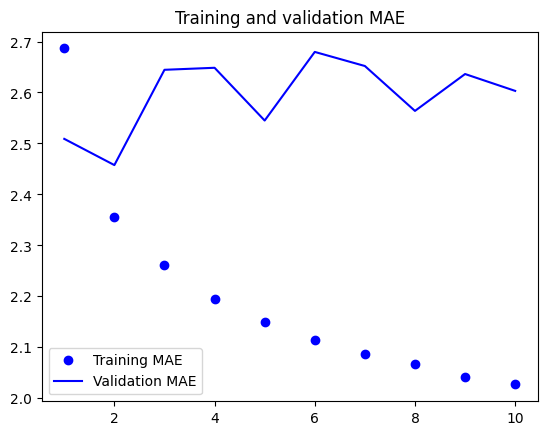

In [12]:
import matplotlib.pyplot as plt

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()



### lets try a 1D convolutional model

the same properties independently of the location of the window). Let’s try one on our temperature-forecasting problem. We’ll pick an initial window length of 24, so that we look at 24 hours of data at a time (one cycle). As we downsample the sequences (via MaxPooling1D layers), we’ll reduce the window size accordingly:

In [13]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu") (inputs)
x = layers.MaxPool1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu") (inputs)
x = layers.MaxPool1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu") (inputs)
x = layers.MaxPool1D(2)(x)
outputs = layers.Dense(1) (x)
model = keras.Model(inputs, outputs)

callbacks = [
	keras.callbacks.ModelCheckpoint("jena_conv.keras",
									save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
	epochs=10,
	validation_data=val_dataset,
	callbacks=callbacks
)
model = keras.models.load_model("jena_conv.keras")
print("Test MAE: %.2f" % model.evaluate(test_dataset)[1])


Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 44s 51ms/step - loss: 100.6121 - mae: 8.1063 - val_loss: 67.7356 - val_mae: 6.7615
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 41s 50ms/step - loss: 77.2944 - mae: 7.1226 - val_loss: 66.1410 - val_mae: 6.6888
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 41s 50ms/step - loss: 76.6268 - mae: 7.0917 - val_loss: 66.2674 - val_mae: 6.6975
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 40s 49ms/step - loss: 76.3691 - mae: 7.0804 - val_loss: 65.2689 - val_mae: 6.6454
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 41s 50ms/step - loss: 76.2821 - mae: 7.0767 - val_loss: 66.0289 - val_mae: 6.6869
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 41s 49ms/step - loss: 76.2365 - mae: 7.0758 - val_loss: 65.5845 - val_mae: 6.6648
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 41s 49ms/step - loss: 76.1690 - mae: 7.0717 - val_loss: 65.8060 - val_mae: 6.6764
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 42s 51ms/step - loss: 76.1810 - mae: 7.0723 - val_loss: 65.4959 - val_mae: 6.6612
Epoch 9/10
819/819 ━━━━

As it turns out, this model performs even worse than the densely connected one, only achieving a validation MAE of about 2.9 degrees, far from the common-sense baseline. What went wrong here? Two things:



*   First, weather data doesn’t quite respect the translation invariance assumption. While the data does feature daily cycles, data from a morning follows different properties than data from an evening or from the middle of the night. Weather data is only translation-invariant for a very specific timescale.
*   Second, order in our data matters—a lot. The recent past is far more informative for predicting the next day’s temperature than data from five days ago. A 1D convnet is not able to leverage this fact. In particular, our max pooling and global average pooling layers are largely destroying order information.



### 10.2.5 A first recurrent baseline

There’s a family of neural network architectures designed specifically for this use case: recurrent neural networks. Among them, the Long Short Term Memory (LSTM) layer has long been very popular.

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 55s 64ms/step - loss: 74.0194 - mae: 6.5717 - val_loss: 12.5316 - val_mae: 2.6771
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 74s 55ms/step - loss: 11.8989 - mae: 2.6521 - val_loss: 9.5579 - val_mae: 2.3984
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 45s 55ms/step - loss: 9.7034 - mae: 2.4288 - val_loss: 9.7531 - val_mae: 2.4216
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 44s 54ms/step - loss: 9.2663 - mae: 2.3728 - val_loss: 9.8745 - val_mae: 2.4395
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 45s 55ms/step - loss: 8.9577 - mae: 2.3339 - val_loss: 9.3462 - val_mae: 2.3779
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 45s 54ms/step - loss: 8.7232 - mae: 2.3036 - val_loss: 9.8478 - val_mae: 2.4336
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 83s 55ms/step - loss: 8.5245 - mae: 2.2727 - val_loss: 9.3857 - val_mae: 2.3770
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 46s 56ms/step - loss: 8.3121 - mae: 2.2449 - val_loss: 9.7449 - val_mae: 2.4170
Epoch 9/10
819/819 ━━━━━━━━━━━━━━━━━━

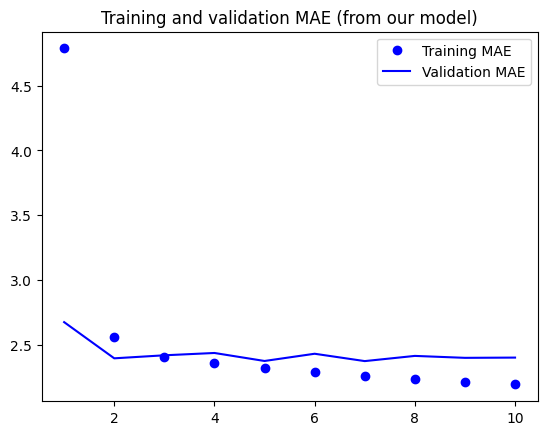

In [14]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
	keras.callbacks.ModelCheckpoint("jena_lstm.keras",
									save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
	epochs=10,
	validation_data=val_dataset,
	callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print("Test MAE: %.2f" % model.evaluate(test_dataset)[1])

#plotting the results:
import matplotlib.pyplot as plt

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE (from our model)")
plt.legend()
plt.show()





advanced usage of recurrent neural networks

we’ll review a number of more advanced features of RNNs, which can help you get the most out of your deep learning sequence models. By the end of the section, you’ll know most of what there is to know about using recurrent networks with Keras. We’ll cover the following:


*   Recurrent dropout—This is a variant of dropout, used to fight overfitting in recurrent layers.
*   Stacking recurrent layers—This increases the representational power of the model (at the cost of higher computational loads).
*   Bidirectional recurrent layers—These present the same information to a recurrent network in different ways, increasing accuracy and mitigating forgetting issues.



10.4.1 Using recurrent dropout to fight overfitting

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x) outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [ keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras", save_best_only=True) ]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)

10.4.2 Stacking recurrent layers

  Because you’re no longer overfitting but seem to have hit a performance bottleneck, you should consider increasing the capacity and expressive power of the network. Recall the description of the universal machine learning workflow: it’s generally a good idea to increase the capacity of your model until overfitting becomes the primary obstacle (assuming you’re already taking basic steps to mitigate overfitting, such as using dropout). As long as you aren’t overfitting too badly, you’re likely under capacity.

  To stack recurrent layers on top of each other in Keras, all intermediate layers should return their full sequence of outputs (a rank-3 tensor) rather than their output at the last timestep. As you’ve already learned, this is done by specifying return_sequences=True.

  In the following example, we’ll try a stack of two dropout-regularized recurrent layers. For a change, we’ll use Gated Recurrent Unit (GRU) layers instead of LSTM. GRU is very similar to LSTM—you can think of it as a slightly simpler, streamlined version of the LSTM architecture.

In [1]:
#Training and evaluating a dropout-regularized, stacked GRU model

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
callbacks = [ keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras", save_best_only=True) ]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(train_dataset, epochs=50, validation_data=val_dataset, callbacks=callbacks)

model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

NameError: name 'keras' is not defined

We achieve a test MAE of 2.39 degrees (an 8.8% improvement over the baseline). You can see that the added layer does improve the results a bit, though not dramatically. You may be seeing diminishing returns from increasing network capacity at this point.

10.4.3 Using bidirectional RNNs

To instantiate a bidirectional RNN in Keras, you use the Bidirectional layer, which takes as its first argument a recurrent layer instance. Bidirectional creates a second, separate instance of this recurrent layer and uses one instance for processing the input sequences in chronological order and the other instance for processing the input sequences in reversed order. You can try it on our temperature-forecasting task.

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16, return_sequences=True))(inputs)
outputs = layers.Dense(1) (x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
callbacks = [ keras.callbacks.ModelCheckpoint("jena_bidir_lstm.keras", save_best_only=True) ]

history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks)


You’ll find that it doesn’t perform as well as the plain LSTM layer. It’s easy to understand why: all the predictive capacity must come from the chronological half of the network, because the antichronological half is known to be severely underperforming on this task (again, because the recent past matters much more than the distant past, in this case). At the same time, the presence of the antichronological half doubles the network’s capacity and causes it to start overfitting much earlier.

However, bidirectional RNNs are a great fit for text data, or any other kind of data where order matters, yet where which order you use doesn’t matter. In fact, for a while in 2016, bidirectional LSTMs were considered the state of the art on many natural language processing tasks (before the rise of the Transformer architecture, which you will learn about in the next chapter).

### 10.4.4 Going even further

There are many other things you could try in order to improve performance on the temperature-forecasting problem:


*   Adjust the number of units in each recurrent layer in the stacked setup, as well as the amount of dropout. The current choices are largely arbitrary and thus probably suboptimal.
*   Adjust the learning rate used by the RMSprop optimizer, or try a different optimizer.
*   Try using a stack of Dense layers as the regressor on top of the recurrent layer, instead of a single Dense layer.
*   Improve the input to the model: try using longer or shorter sequences or a different sampling rate, or start doing feature engineering.



a caminho de facer isso, vou pegar o dropout-regularized sacked GRU model.